In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sb

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-lightgmb/final_lgbm_model.pkl
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


In [2]:
%%time
train_data = pd.read_csv('../input/jane-street-market-prediction/train.csv')

CPU times: user 1min 29s, sys: 6.31 s, total: 1min 35s
Wall time: 2min 44s


In [3]:
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))
train_data = train_data[train_data['weight'] != 0]

In [4]:
outcomes = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'action', 'ts_id']
predictors = list(filter(lambda x: x not in outcomes, train_data.columns))
outcome = ['action']

In [5]:
full_val_set = train_data[(train_data.date > 349) & (train_data.date <= 399)]
full_test_set = train_data[train_data.date > 399]

In [6]:
for column in list(set(outcomes) - set(outcome)):
    train_data.drop(column, axis=1, inplace=True)

In [7]:
train_data.fillna(method='ffill', inplace=True)

In [8]:
train_set = train_data[train_data.date <= 349]
val_set = train_data[(train_data.date > 349) & (train_data.date <= 399)]
test_set = train_data[train_data.date > 399]

print(train_set.date.nunique(), val_set.date.nunique(), test_set.date.nunique())

350 50 100


In [9]:
X_train, X_val, X_test = train_set[predictors], val_set[predictors], test_set[predictors]

y_train, y_val, y_test = train_set[outcome].values.reshape(len(train_set),), val_set[outcome].values.reshape(len(val_set),), test_set[outcome].values.reshape(len(test_set),)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1335699, 132) (1335699,) (208665, 132) (208665,) (436923, 132) (436923,)


In [10]:
X_train = tf.keras.utils.normalize(X_train)
X_val = tf.keras.utils.normalize(X_val)
X_test = tf.keras.utils.normalize(X_test)

In [11]:
EPOCHS = 100
BATCH_SIZE = 32
INPUT_LENGTH = 10

generator_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    X_train, y_train,
    length=INPUT_LENGTH,
    batch_size=BATCH_SIZE)

generator_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    X_val, y_val,
    length=INPUT_LENGTH,
    batch_size=BATCH_SIZE)

generator_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    X_test, y_test,
    length=INPUT_LENGTH,
    batch_size=BATCH_SIZE)

In [36]:
'''
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.python.keras.layers import CuDNNLSTM

model = tf.keras.models.Sequential()

model.add(CuDNNLSTM(len(train_data.columns) - 1, 
                    input_shape=(INPUT_LENGTH, len(train_data.columns) - 1), 
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#model.add(CuDNNLSTM(16, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=["accuracy"])

model.summary()

model.fit(generator_train, 
          validation_data = generator_val, 
          epochs = EPOCHS, 
          steps_per_epoch = STEPS,
          validation_steps = STEPS/10,
          verbose = 1,
          callbacks = [EarlyStopping(monitor='loss', verbose=1, patience=10),
                       EarlyStopping(monitor='val_loss', verbose=1, patience=10)])

''';

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 10, 132)           140448    
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 132)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 132)           528       
_________________________________________________________________
dense_8 (Dense)              (None, 10, 8)             1064      
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 8)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 10, 1)             9         
Total params: 142,049
Trainable params: 141,785
Non-trainable params: 264
_____________________________________________

In [12]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    len(train_data.columns) - 1, 
    input_shape=(INPUT_LENGTH, len(train_data.columns) - 1),
    return_sequences=True))

model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(8, activation='relu'))

model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.optimizers.Adam(learning_rate=0.005),
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 132)           139920    
_________________________________________________________________
dropout (Dropout)            (None, 10, 132)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 8)             1064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 8)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10, 1)             9         
Total params: 140,993
Trainable params: 140,993
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(
    generator_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generator_val,
    validation_steps=len(generator_val)//BATCH_SIZE,
    verbose = 1)

500/500 [==============================] - 102s 192ms/step - loss: 0.6936 - accuracy: 0.4927 - val_loss: 0.6927 - val_accuracy: 0.5165


In [14]:
model.evaluate(generator_test, verbose=1)

13654/13654 [==============================] - 1848s 135ms/step - loss: 0.6935 - accuracy: 0.4957


[0.6934821605682373, 0.4956776201725006]

In [15]:
y_pred_lstm = model.predict_proba(generator_val, verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


6521/6521 [==============================] - 879s 135ms/step


In [17]:
#model = tf.keras.models.load_model('lstm_model.h5')

In [41]:
def utility_score_last(date, weight, resp, action):
    count_i = date.nunique() # Get number of days
    P_i = np.bincount(date, weight * resp * action) # Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) # Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) # Combine to get utility score
    return u

def get_utility_from_df(df, weight=0.5):
    weighted_predictions = y_pred_lstm
    return utility_score_last(df.date, df.weight, df.resp, np.round(weighted_predictions).astype(int))

In [42]:
weights =  np.linspace(0, 1, 200)
utility_by_weight = [get_utility_from_df(full_val_set, weight) for weight in weights]

In [43]:
best_weights = weights[utility_by_weight.index(max(utility_by_weight))]

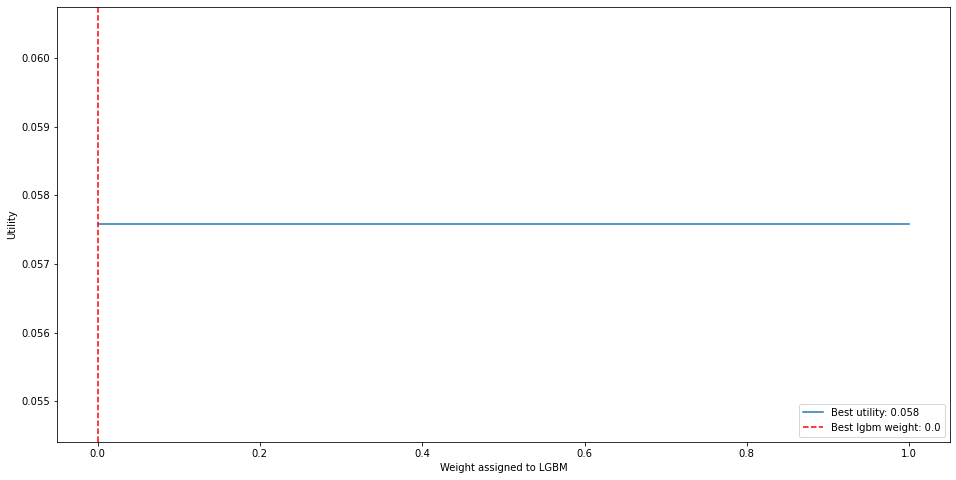

In [44]:
# Visualize
plt.figure(figsize=(16, 8))
plt.plot(weights, utility_by_weight, label="Best utility: %s"%np.round(max(utility_by_weight), 3))
plt.axvline(best_lgbm_weights, color="red", linestyle="--",label="Best lgbm weight: %s"%np.round(best_lgbm_weights, 3))
plt.ylabel("Utility"); plt.xlabel("Weight assigned to LGBM")
plt.legend(loc=4); plt.show()

In [54]:
full_val_set.lstm_predicted_prob

1403070    0.515290
1403077    0.483089
1403080    0.406960
1403082    0.546355
1403083    0.543934
             ...   
1878256    0.431247
1878262    0.575855
1878271    0.568233
1878272    0.601380
1878274    0.438427
Name: lstm_predicted_prob, Length: 404395, dtype: float64

In [ ]:
'''
import joblib
gbm_pickle = joblib.load('../input/model-lightgmb/final_lgbm_model.pkl')
gbm_pickle

import janestreet
from tqdm import tqdm
import numpy as np

env = janestreet.make_env()

for (test_df, pred_df) in tqdm(env.iter_test()):
    
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, feat].values
        
        xgb_pred = gbm_pickle.predict_proba(x_tt)[0][1]
        print(xgb_pred)
        
        pred_df.action = np.where(xgb_pred >= 0.513, 1, 0).astype(int)
    else:
        pred_df.action = 0
    
    env.predict(pred_df)''';